# Задание 4

## 1.	Выберите любой файл в формате EDF.

In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
from scipy import signal
import pywt
from scipy.signal import spectrogram
import os
import pandas as pd


edf_file_path = "EEG1/eeg1.edf" 
annotations_file_path = "EEG1/annotations_2017_A.csv"  # Файл с аннотациями


if not os.path.exists(edf_file_path):
    raise FileNotFoundError(f"Файл {edf_file_path} не найден")
if not os.path.exists(annotations_file_path):
    raise FileNotFoundError(f"Файл {annotations_file_path} не найден")

Чтение аннотаций из CSV
annotations_df = pd.read_csv(annotations_file_path)

Чтение EDF файла
try:
    edf_file = pyedflib.EdfReader(edf_file_path)
    
    
    n_channels = edf_file.signals_in_file
    channel_names = edf_file.getSignalLabels()
    fs = edf_file.getSampleFrequencies()[0]  # Частота дискретизации основного сигнала
    
    
    n_samples = edf_file.getNSamples()[0]
    print(f"Размерность данных: ({n_channels}, {n_samples})")
    
    # Чтение всех каналов
    eeg_data = np.zeros((n_channels, n_samples))
    for i in range(n_channels):
        eeg_data[i, :] = edf_file.readSignal(i)
    
    # Получение временной оси
    time = np.arange(n_samples) / fs
    
finally:
    edf_file.close()



Размерность данных: (21, 1790208)


In [2]:
file_annotations = annotations_df['1']
# Фильтруем только приступы (тип 'seizure')
seizure_annotations = file_annotations[file_annotations == 1]

In [4]:
def find_event_intervals_by_gaps(series):
    '''
    поиск индущих подряд интервалов в индексах pd.Series 
    для определения границ приступов
    '''
    intervals = []
    start = None
    
    for index in series.index:
        if start is None:
            start = index
        if index != series.index[series.index.get_loc(index) - 1] + 1 and index != series.index[0]:
            end = series.index[series.index.get_loc(index) - 1]
            intervals.append((start, end))
            start = index
    
    # Добавляем последний интервал
    intervals.append((start, series.index[-1]))
    
    return intervals

In [5]:
find_event_intervals_by_gaps(seizure_annotations)

[(103, 120),
 (316, 450),
 (741, 799),
 (953, 981),
 (1178, 1208),
 (1593, 1641),
 (1650, 1706),
 (2848, 2870),
 (3007, 3093),
 (3256, 3278),
 (3851, 3881),
 (3992, 4084),
 (4404, 4507),
 (4587, 4620),
 (4778, 4802),
 (4828, 4851),
 (4961, 5038),
 (5140, 5261),
 (5542, 5615),
 (6064, 6396),
 (6488, 6506),
 (6549, 6571),
 (6604, 6702),
 (6783, 6797),
 (6846, 6862)]

## 2.	По аннотации из датасета определите, где в записи ЭЭГ указан приступ. Постройте график временной зависимости ЭЭГ в момент приступа (выбирайте диапазон времени и масштаб так, чтобы было наглядно).

seizure time: 103 - 120
Приступ с 103с по 120с -> индексы 26368-30720


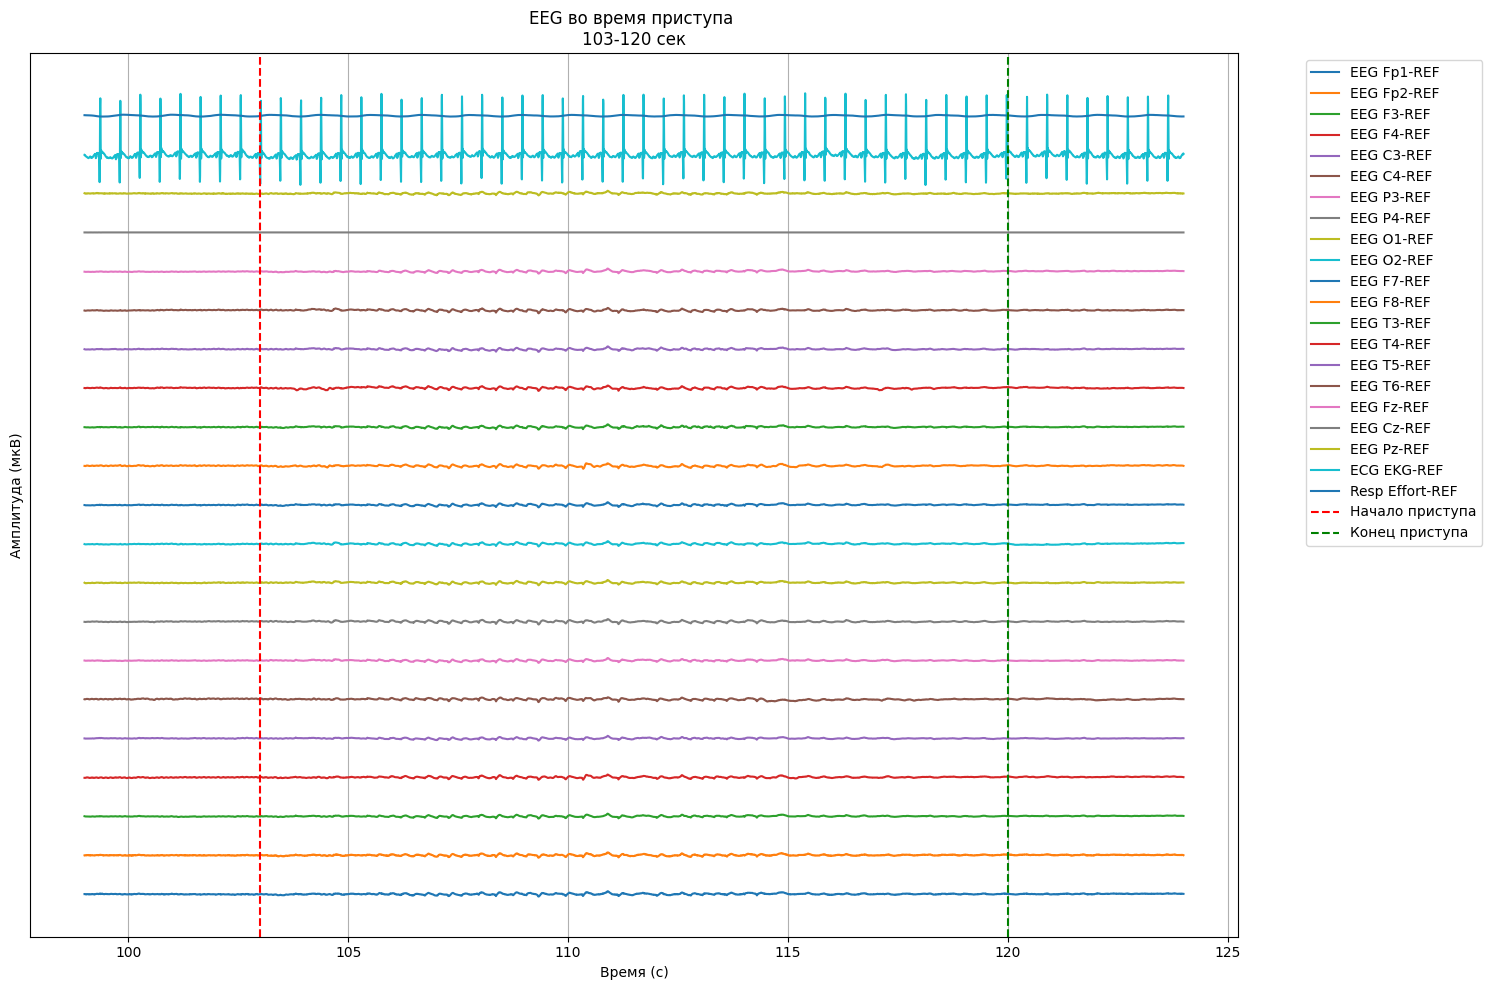

In [6]:
# Берем первый приступ
seizure_times = find_event_intervals_by_gaps(seizure_annotations)

num = 0
seizure_start = seizure_times[num][0]
seizure_end = seizure_times[num][-1]

print(f'seizure time: {seizure_start} - {seizure_end}')

# Преобразуем время в индексы с учетом частоты дискретизации ЭЭГ
start_idx = int(seizure_start * fs)
end_idx = int(seizure_end * fs)

# Проверка, чтобы индексы не выходили за границы
start_idx = max(0, start_idx)
end_idx = min(n_samples, end_idx)

print(f"Приступ с {seizure_start}с по {seizure_end}с -> индексы {start_idx}-{end_idx}")

# Выбираем участок для визуализации (2 секунды)
duration_plot = 25  # секунды
plot_samples = int(duration_plot * fs)
middle_idx = (start_idx + end_idx) // 2
plot_start = max(0, middle_idx - plot_samples // 2)
plot_end = min(n_samples, middle_idx + plot_samples // 2)

# Построение графика для всех каналов
plt.figure(figsize=(15, 10))
for i in range(n_channels):
    plt.plot(time[plot_start:plot_end], eeg_data[i, plot_start:plot_end] + i * 500, label=channel_names[i])


# Добавляем вертикальные линии для начала и конца приступа
plt.axvline(x=seizure_start, color='r', linestyle='--', linewidth=1.5, label='Начало приступа')
plt.axvline(x=seizure_end, color='g', linestyle='--', linewidth=1.5, label='Конец приступа')

plt.title(f'EEG во время приступа \n{seizure_start}-{seizure_end} сек')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда (мкВ)')
plt.yticks([])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


seizure time: 103 - 120
Приступ с 103с по 120с -> индексы 26368-30720


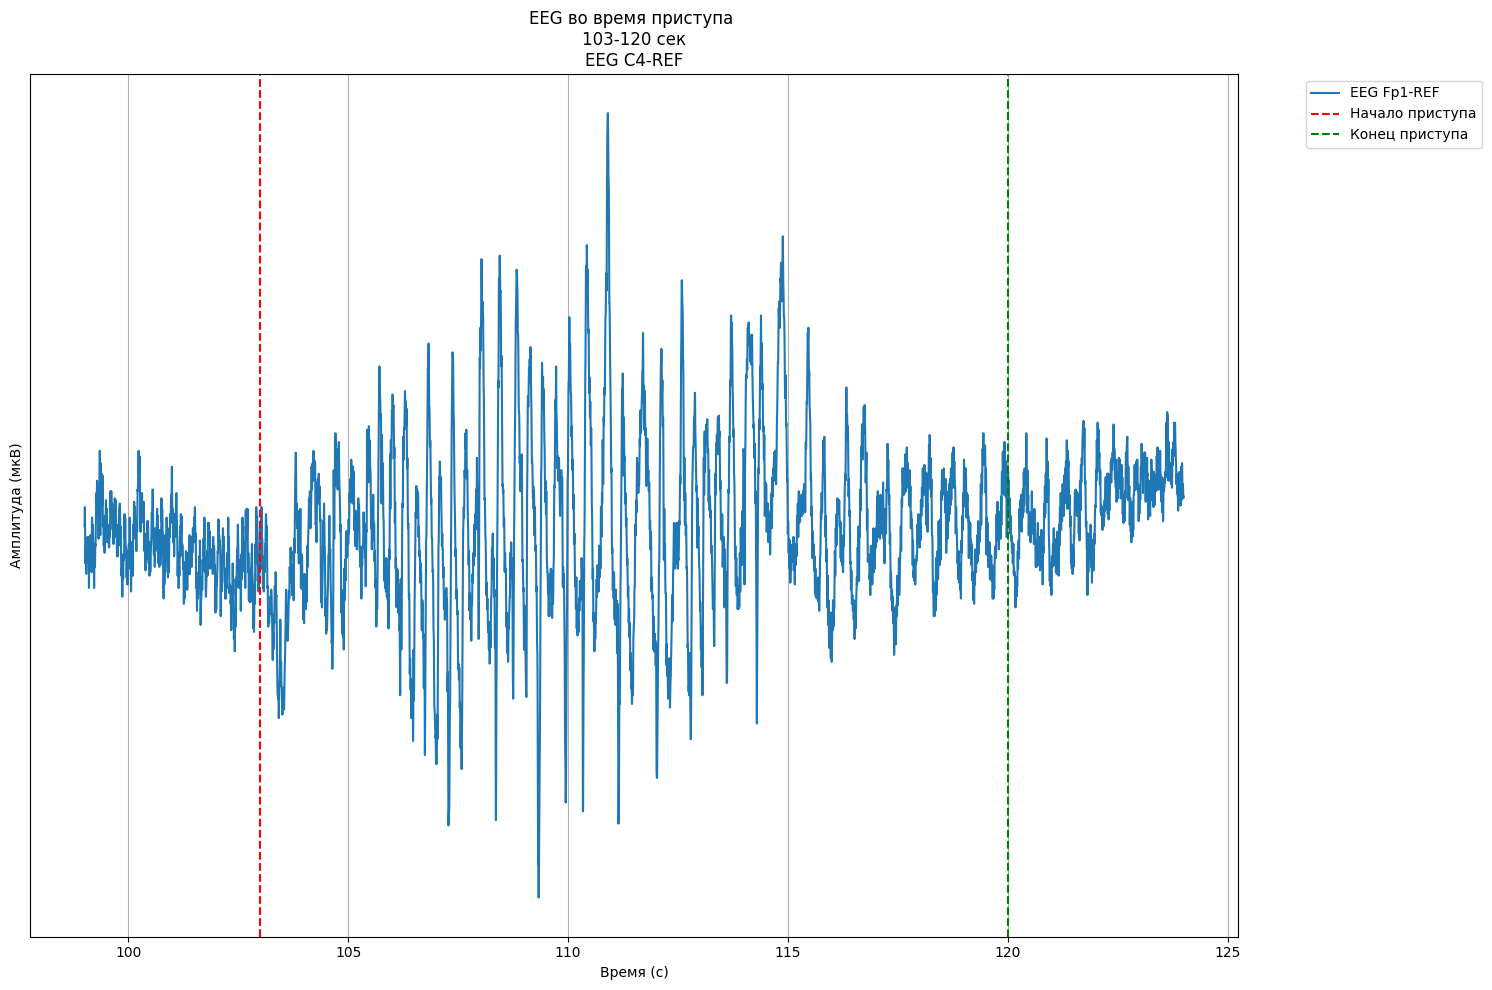

In [7]:
# Берем первый приступ
seizure_times = find_event_intervals_by_gaps(seizure_annotations)

num = 0
seizure_start = seizure_times[num][0]
seizure_end = seizure_times[num][-1]

print(f'seizure time: {seizure_start} - {seizure_end}')

# Преобразуем время в индексы с учетом частоты дискретизации ЭЭГ
start_idx = int(seizure_start * fs)
end_idx = int(seizure_end * fs)

# Проверка, чтобы индексы не выходили за границы
start_idx = max(0, start_idx)
end_idx = min(n_samples, end_idx)

print(f"Приступ с {seizure_start}с по {seizure_end}с -> индексы {start_idx}-{end_idx}")

# Выбираем участок для визуализации (2 секунды)
duration_plot = 25  # секунды
plot_samples = int(duration_plot * fs)
middle_idx = (start_idx + end_idx) // 2
plot_start = max(0, middle_idx - plot_samples // 2)
plot_end = min(n_samples, middle_idx + plot_samples // 2)

plt.figure(figsize=(15, 10))


plt.plot(time[plot_start:plot_end], eeg_data[0, plot_start:plot_end] +  500, label=channel_names[0])

# Добавляем вертикальные линии для начала и конца приступа
plt.axvline(x=seizure_start, color='r', linestyle='--', linewidth=1.5, label='Начало приступа')
plt.axvline(x=seizure_end, color='g', linestyle='--', linewidth=1.5, label='Конец приступа')

plt.title(f'EEG во время приступа \n{seizure_start}-{seizure_end} сек\n{channel_names[5]}')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда (мкВ)')
plt.yticks([])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3.	Сделайте усреднение всех каналов ЭЭГ в один (нужно сложить все каналы и разделить на их количество)

In [8]:
avg_eeg = np.mean(eeg_data, axis=0)

## 4.	Удалите из сигнала все частоты выше 60 Гц.

In [9]:
nyquist = 0.5 * fs
cutoff = 60.0 / nyquist
b, a = signal.butter(4, cutoff, btype='low')
filtered_eeg = signal.filtfilt(b, a, avg_eeg)

### Для этого преобразованного сигнала:	постройте спектрограмму сигнала

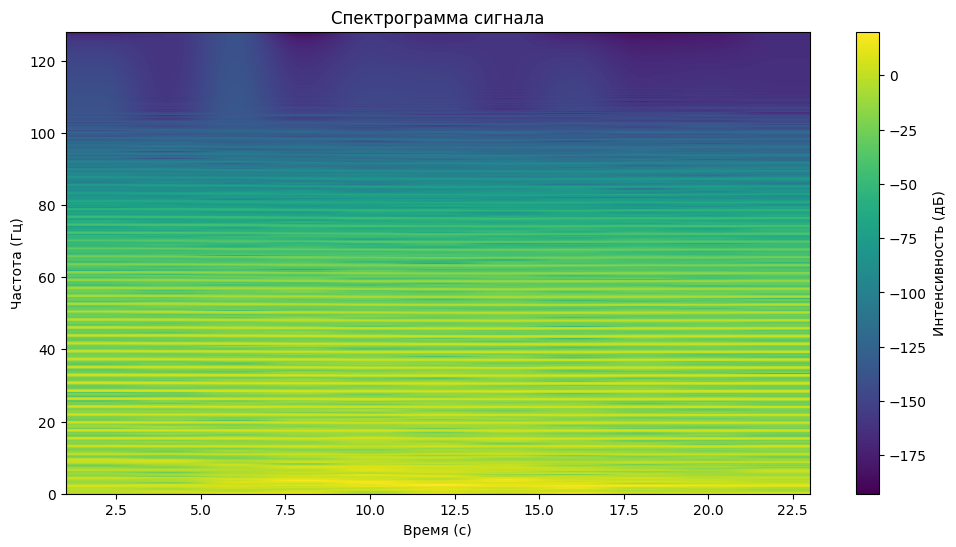

In [10]:
plt.figure(figsize=(12, 6))
# во время первого приступа
plt.specgram(filtered_eeg[plot_start:plot_end], Fs=fs, NFFT=1024, noverlap=512)
plt.title("Спектрограмма сигнала")
plt.xlabel("Время (с)")
plt.ylabel("Частота (Гц)")
plt.colorbar(label="Интенсивность (дБ)")
plt.show()


/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


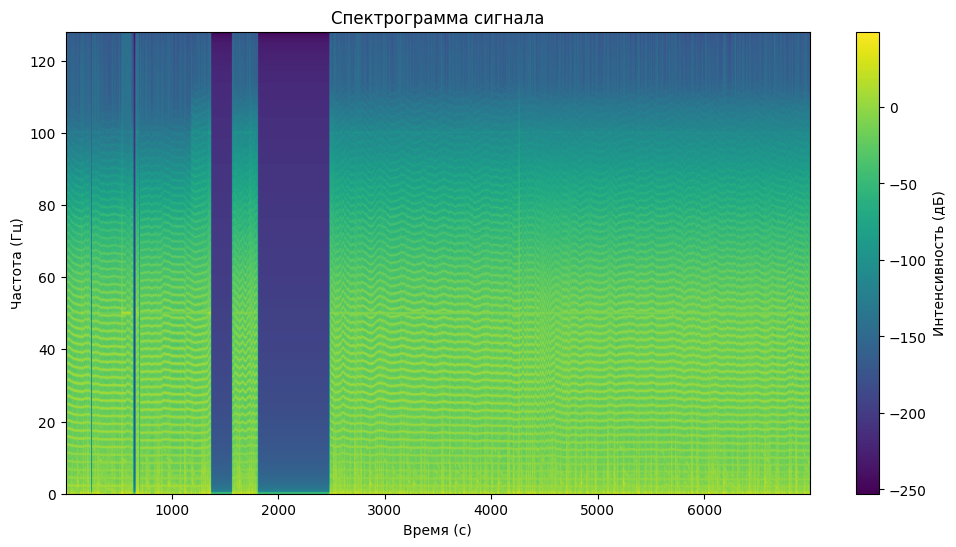

In [11]:
# на всем времени
plt.figure(figsize=(12, 6))
plt.specgram(filtered_eeg, Fs=fs, NFFT=1024, noverlap=512)
plt.title("Спектрограмма сигнала")
plt.xlabel("Время (с)")
plt.ylabel("Частота (Гц)")
plt.colorbar(label="Интенсивность (дБ)")
plt.show()


### постройте вейвлет-преобразование (скейлограмму)

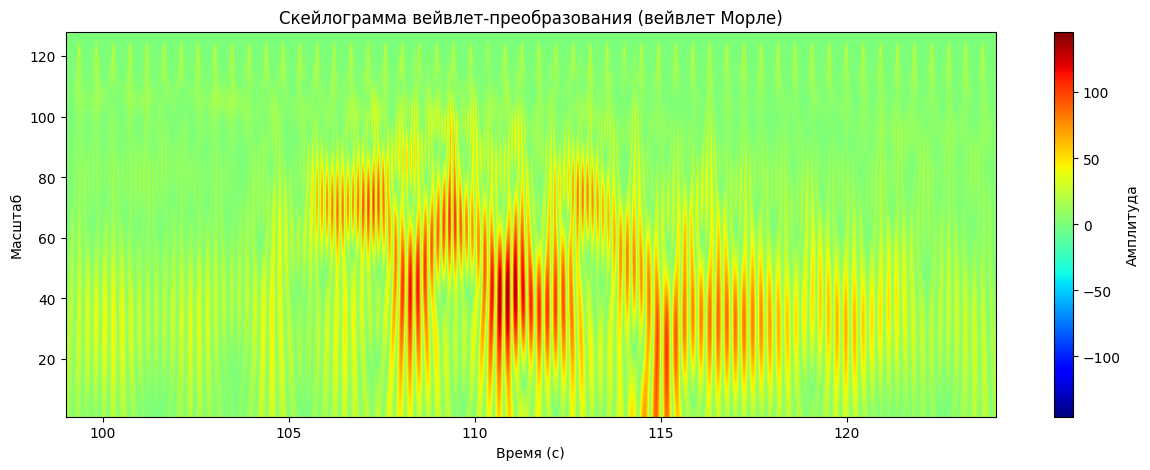

In [12]:
wavelet = 'morl'
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(filtered_eeg[plot_start:plot_end], scales, wavelet, sampling_period=1/fs)

plt.figure(figsize=(15, 5))
plt.imshow(np.abs(coefficients), extent=[time[plot_start], time[plot_end], 1, 128], 
           cmap='jet', aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
plt.colorbar(label='Амплитуда')
plt.title('Скейлограмма вейвлет-преобразования (вейвлет Морле)')
plt.xlabel('Время (с)')
plt.ylabel('Масштаб')
plt.show()